Solving complex physical systems (PDEs) with AI usually requires massive datasets, which can be impractical to get. 

We ask the following question: <span style="color: red;">what if we only needed one example?</span> 

Here, we introduce a novel "one-shot learning" method that learns to solve PDEs from a single solution data point with the following example.

## Learning the solution operator for a nonlinear PDE

We consider a nonlinear diffusion-reaction equation with a source term f(x):

$$
\frac{\partial u}{\partial t}
= D \frac{\partial^2 u}{\partial x^2}
+ k u^2 + f(x),
\quad x \in [0,1], \; t \in [0,1]
$$

with zero initial and boundary conditions, where D = 0.01 is the diffusion coefficient, and k = 0.01 is the reaction rate.

Our goal is to learn the solution operator of an **unknown** underlying PDE system with suitable IC/BCs that maps variable inputs to the corresponding
solutions. 

In this example, we aim to learn the solution operator $\mathcal{G}: f \mapsto u$ for a class of $f = f_0 + \Delta f$ with $f_0 = 0.9 \sin(2\pi x)$.

#### Load libraries

In [2]:
import os
import time
import random
from scipy import interpolate
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
dde.backend.set_default_backend('tensorflow.compat.v1')
dde.config.set_default_float("float64")
dde.config.disable_xla_jit()

Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Set the default float type to float64
Disable just-in-time compilation with XLA.



In [3]:
fontsize=16
fig_params = {
    'font.size': fontsize,
    "savefig.dpi": 300, 
    "figure.figsize": (4, 3),
    "axes.facecolor":   "white",
    "figure.facecolor": "white",
    "axes.grid":        False,
    "axes.edgecolor":   "black",
    "xtick.color":      "black",
    "ytick.color":      "black",
    "xtick.bottom":   True,
    "ytick.left":     True,
    'lines.linewidth': 1.5,
    'axes.linewidth': 1.5,
    'axes.titlesize' : fontsize,
    "axes.labelsize":fontsize-1.5,
    "xtick.labelsize":fontsize-1.5,
    "ytick.labelsize":fontsize-1.5,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'xtick.major.size': 3,
    'xtick.minor.size': 2,
    'xtick.major.width': 1,
    'xtick.minor.width': 1,
    'xtick.major.pad': 6,
    'xtick.minor.pad': 5,
    'ytick.major.pad': 6,
    'ytick.minor.pad': 5,
    'ytick.major.size': 3,
    'ytick.minor.size': 2,
    'ytick.major.width': 1,
    'ytick.minor.width': 1,
    "mathtext.fontset":"cm",
}
plt.rcParams.update(fig_params)

def plot_data(fname, uname, dname):
    # x = np.loadtxt(f"{dname}/x_grid.dat")
    f = np.loadtxt(f"{dname}/{fname}.dat")
    u = np.loadtxt(f"{dname}/{uname}.dat")
    f = np.rot90(f)
    u = np.rot90(u)
    print("({}, {})".format(fname, uname))
    plt.figure()
    plt.plot(f[0])
    plt.xlabel("x")
    plt.ylabel(f"${fname}$")
    # plt.savefig(f"{dname}/{fname}.png")

    plt.figure()
    plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
    plt.imshow(u,  origin='upper', cmap = "rainbow", extent=(0,1,0,1), aspect='auto')
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("t")
    # plt.savefig(f"{dname}/{uname}.png")
    plt.show()

### "One-shot" training data

We randomly generate one data point $\mathcal{T} = \{(f_{\mathcal{T}}, u_{\mathcal{T}})\}$ with $|\mathcal{T}| = 1$ for training.

Note that here “one-shot” represents one input-output data pair in the context of operator learning.

Loaded f_T (1001, 1001) and u_T (1001, 1001) for training the local solution operator.
(f_T, u_T)


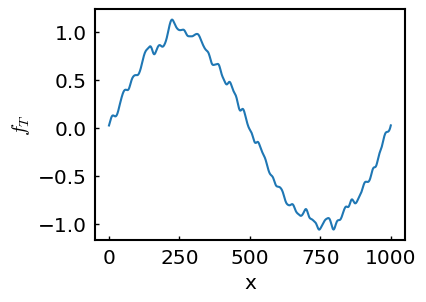

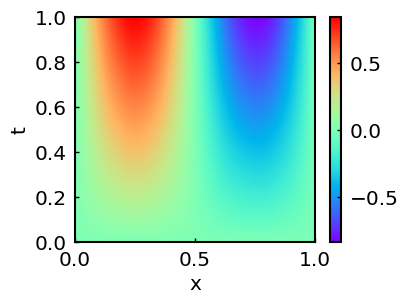

In [4]:
# Create folders for the datasets
new_dir = "data_nonlinear_diffusion"
parent_dir = "../../data/"
PATH = os.path.join(parent_dir, new_dir)

f_T = np.loadtxt(f"{PATH}/data_G/f_T.dat")
u_T = np.loadtxt(f"{PATH}/data_G/u_T.dat")
print(f"Loaded f_T {f_T.shape} and u_T {u_T.shape} for training the local solution operator.")

plot_data("f_T", "u_T", f"{PATH}/data_G")

### Step 1: Select a “canonical” local domain $\tilde \Omega$

Since it is a time-dependent problem, we include the previous temporal node and select the local domain $\tilde \Omega$:

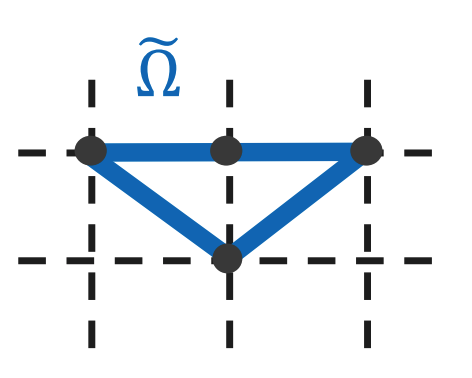

### Step 2: Select a local solution operator $\widetilde{\mathcal{G}}$

We select the simplest local solution operator defined on a local domain with 4 spatial-temporal nodes:

$$
\widetilde{\mathcal{G}}: \{u(x, t - \Delta t),\, u(x - \Delta x, t),\, u(x + \Delta x, t),\, f(x, t)\} \mapsto u(x, t).
$$

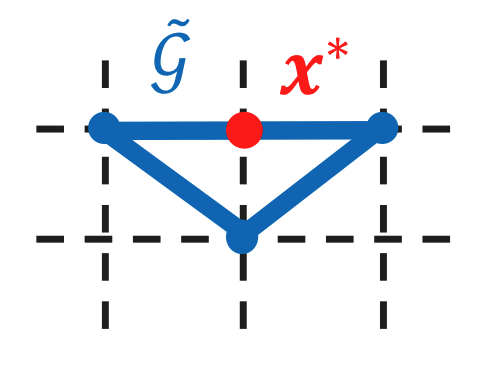

### Step 3: Train a local solution operator $\widetilde{\mathcal{G}}$

Utilizing the dataset $\mathcal{T} = (f_{\mathcal{T}}, u_{\mathcal{T}})$, we place the local domain $\tilde{\Omega}$ at different locations of $\Omega$, which can be either a global structured mesh or randomly sampled locations. This process generates many input–output data pairs for training $\tilde{\mathcal{G}}$.

In [6]:
def construct_more_data(Nx, Nt, f, u):
    # u[i-1, j], u[i, j-1], u[i+1, j], f[i, j]
    M = len(f)
    xstep = int((M-1)/(Nx-1))
    tstep = int((M-1)/(Nt-1))
    outputs = u[xstep: -xstep, tstep:].reshape((-1, 1))
    inputs = np.hstack((u[:-2*xstep, tstep:].reshape((-1, 1)), u[xstep: -xstep, :-tstep].reshape((-1, 1)), u[2*xstep: , tstep:].reshape((-1, 1)), f[xstep: -xstep, tstep:].reshape((-1, 1))))
    return inputs, outputs

def pre_trained_NN(data, layers):
    net = dde.nn.FNN(layers, "tanh", "Glorot normal", use_bias=True, regularization=['l2', 1e-8])
    model = dde.Model(data, net)
    checker = dde.callbacks.ModelCheckpoint(f"nonlinear_diffusion/model/model.ckpt", save_better_only=True, period=100000)
    model.compile("adam",lr=1e-3, decay = ("inverse time", 20000, 0.5), metrics=["l2 relative error"])
    losshistory, train_state = model.train(epochs=150000,callbacks=[checker])
    model.compile("L-BFGS-B", metrics=["l2 relative error"])
    losshistory, train_state = model.train(callbacks=[checker], model_save_path = f"nonlinear_diffusion/model/model.ckpt")
    return model, str(train_state.best_step)

Nx, Nt = 101, 101
d_T = construct_more_data(Nx, Nt, f_T, u_T)
f_0 = np.loadtxt(f"{PATH}/data_0.50/data_0/f_0_grid.dat")
u_0 = np.loadtxt(f"{PATH}/data_0.50/data_0/u_0_grid.dat")
print(f"Loaded f_0_grid {f_0.shape} and u_0_grid {u_0.shape} for testing the local solution operator.")
d_0 = construct_more_data(Nx, Nt, f_0, u_0)

dataset_G = dde.data.DataSet(X_train=d_T[0], y_train=d_T[1], X_test=d_0[0], y_test=d_0[1])

pre_layers = [4, 64, 1]
print(pre_layers)
model, best_step = pre_trained_NN(dataset_G, pre_layers)

Loaded f_0_grid (101, 101) and u_0_grid (101, 101) for testing the local solution operator.
[4, 64, 1]
Compiling model...
Building feed-forward neural network...
'build' took 0.021618 s

'compile' took 0.225687 s



/gpfs/radev/home/aj733/.conda/envs/tf-condacuda/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2025-10-07 16:06:15.405822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-07 16:06:15.537757: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-10-07 16:06:15.537796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/ta

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [1.25e-02, 9.42e-08]    [1.22e-02, 9.42e-08]    [3.09e-01]    


2025-10-07 16:06:15.611781: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


1000      [7.47e-06, 9.48e-08]    [7.05e-06, 9.48e-08]    [7.42e-03]    
2000      [1.02e-06, 9.52e-08]    [9.21e-07, 9.52e-08]    [2.68e-03]    
3000      [4.41e-07, 9.53e-08]    [3.65e-07, 9.53e-08]    [1.69e-03]    
4000      [2.22e-07, 9.51e-08]    [1.72e-07, 9.51e-08]    [1.16e-03]    
5000      [1.65e-07, 9.49e-08]    [1.30e-07, 9.49e-08]    [1.01e-03]    
6000      [1.11e-07, 9.46e-08]    [8.30e-08, 9.46e-08]    [8.04e-04]    
7000      [9.16e-08, 9.44e-08]    [6.86e-08, 9.44e-08]    [7.31e-04]    
8000      [7.83e-08, 9.41e-08]    [5.89e-08, 9.41e-08]    [6.78e-04]    
9000      [6.80e-08, 9.38e-08]    [5.19e-08, 9.38e-08]    [6.36e-04]    
10000     [5.97e-08, 9.36e-08]    [4.50e-08, 9.36e-08]    [5.92e-04]    
11000     [5.41e-08, 9.33e-08]    [4.08e-08, 9.33e-08]    [5.64e-04]    
12000     [5.91e-08, 9.30e-08]    [4.98e-08, 9.30e-08]    [6.23e-04]    
13000     [4.62e-08, 9.27e-08]    [3.54e-08, 9.27e-08]    [5.25e-04]    
14000     [4.37e-08, 9.25e-08]    [3.41e-08, 9.25e-

### Step 4: Predict the solution $u$ for a new input function $f$ with suitable IC/BCs.

For a new PDE condition $f$, we choose one of the three approaches to find the global PDE solution using the pre-trained local solution operator $\tilde{\mathcal{G}}$: fixed-point iteration (FPI), local-solution-operator-informed neural network (LOINN), or local-solution-operator-informed neural network with correction (cLOINN).

#### Approach 1: FPI

Loaded f_T (1001, 1001) and u_T (1001, 1001) for training the local solution operator.
Loaded f_0_grid (101, 101) and u_0_grid (101, 101) for testing the local solution operator.
Loaded u_new_grid (10201, 2) for x_train and x_test.
Dataset generated for FPI/LOINN-grid (x_train, y_train, x_test, y_test).
Compiling model...
Building feed-forward neural network...
'build' took 0.016823 s

'compile' took 0.088708 s

Compiling model...
'compile' took 0.026137 s

Restoring model from nonlinear_diffusion/model/model.ckpt-161943.ckpt ...

INFO:tensorflow:Restoring parameters from nonlinear_diffusion/model/model.ckpt-161943.ckpt
Dataset 0
0.7944982046847552
0 0.7886765352825049


2025-10-07 16:40:10.101562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


100 0.37082171244433587
200 0.1382322511256478
300 0.034288280472260325
400 0.03036830038842253
Error after 500 iterations: 0.030367913416652965
Minimum error is  0.030367913416652965
One-shot took 1.2884376049041748 s.


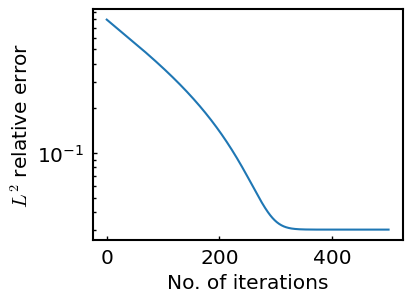

The average l2 error is  0.030367913416652965


In [8]:
import tensorflow.compat.v1 as tf
tf.reset_default_graph()

def load_all_data(M, Nx, Nt, N_f, N_b, l, a, l_new, a_new, dname, gen = False, correction = False, grid = False, isplot = False):
    if gen:
        print("Generate new datasets ... ")
        gen_data_GRF(M, Nx, Nt, l, a, dname, isplot)
        interp_u0 = gen_test_data(M, Nx, Nt, dname, isplot)
        gen_new_data_GRF(M, Nx, Nt, N_f, N_b, dname, a_new, l_new, isplot)
        gen_data_correction(interp_u0, dname, isplot)
    
    PATH = "../../data/data_nonlinear_diffusion"
    f_T = np.loadtxt(f"{PATH}/data_G/f_T.dat")
    u_T = np.loadtxt(f"{PATH}/data_G/u_T.dat")
    print(f"Loaded f_T {f_T.shape} and u_T {u_T.shape} for training the local solution operator.")
    d_T = construct_more_data(Nx, Nt, f_T, u_T)

    f_0 = np.loadtxt(f"{dname}/f_0_grid.dat")
    u_0 = np.loadtxt(f"{dname}/u_0_grid.dat")
    print(f"Loaded f_0_grid {f_0.shape} and u_0_grid {u_0.shape} for testing the local solution operator.")
    d_0 = construct_more_data(Nx, Nt, f_0, u_0)

    data_G = dde.data.DataSet(X_train=d_T[0], y_train=d_T[1], X_test=d_0[0], y_test=d_0[1])
    
    if not grid:
        x_train = np.loadtxt(f"{dname}/u_new.dat")[:, 0:2]
        x = np.loadtxt(f"{dname}/x_grid.dat").reshape((-1, 1))
        t = np.loadtxt(f"{dname}/t_grid.dat").reshape((-1, 1))
        x_test = np.concatenate((x, t), axis = 1)
        print(f"Loaded u_new {x_train.shape} and u_new_grid {x_test.shape} for x_train and x_test.")
        y_train = np.concatenate(([[0] * len(x_train)])).reshape((-1, 1))

        if correction:
            # For cLOINN-random
            u_new = np.loadtxt(f"{dname}/u_new_grid.dat").reshape((-1, 1))
            u_init = np.loadtxt(f"{dname}/u_0_grid.dat").reshape((-1, 1))
            y_test = u_new - u_init
            print("Dataset generated for cLOINN-random (x_train, y_train, x_test, y_test).")
        else:
            # For FPI and LOINN-random
            y_test = np.loadtxt(f"{dname}/u_new_grid.dat").reshape((-1, 1))
            print("Dataset generated for LOINN-random (x_train, y_train, x_test, y_test).")
    
    else:
        x = np.loadtxt(f"{dname}/x_grid.dat").reshape((-1, 1))
        t = np.loadtxt(f"{dname}/t_grid.dat").reshape((-1, 1))
        x_train = np.concatenate((x, t), axis = 1)
        x_test = x_train
        print(f"Loaded u_new_grid {x_train.shape} for x_train and x_test.")
        y_train = np.concatenate(([[0] * len(x_train)])).reshape((-1, 1))

        if correction:
            # For cLOINN-grid
            u_new = np.loadtxt(f"{dname}/u_new_grid.dat").reshape((-1, 1))
            u_init = np.loadtxt(f"{dname}/u_0_grid.dat").reshape((-1, 1))
            y_test = u_new - u_init
            print("Dataset generated for cLOINN-grid (x_train, y_train, x_test, y_test).")
        else:
            # For FPI and LOINN-grid
            y_test = np.loadtxt(f"{dname}/u_new_grid.dat").reshape((-1, 1))
            print("Dataset generated for FPI/LOINN-grid (x_train, y_train, x_test, y_test).")

    data = dde.data.DataSet(X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test)
    return data_G, data

def construct_more_data(Nx, Nt, f, u):
    # u[i-1, j], u[i, j-1], u[i+1, j], f[i, j]
    M = len(f)
    xstep = int((M-1)/(Nx-1))
    tstep = int((M-1)/(Nt-1))
    outputs = u[xstep: -xstep, tstep:].reshape((-1, 1))
    inputs = np.hstack((u[:-2*xstep, tstep:].reshape((-1, 1)), u[xstep: -xstep, :-tstep].reshape((-1, 1)), u[2*xstep: , tstep:].reshape((-1, 1)), f[xstep: -xstep, tstep:].reshape((-1, 1))))
    return inputs, outputs

def construct_data(f, u):
    Nx, Nt = f.shape
    u_inside = u[1:-1, 1:]
    outputs = u_inside.reshape((-1, 1))
    inputs = np.hstack((u[:-2, 1:].reshape((-1, 1)), u[1:-1, :-1].reshape((-1, 1)), u[2:, 1:].reshape((-1, 1)), f[1:-1, 1:].reshape((-1, 1))))
    return np.array(inputs), np.array(outputs)

def load_trained_model(data, layers, best_step):
    net = dde.nn.FNN(layers, "tanh", "LeCun normal", use_bias = True, regularization=['l2', 1e-8])
    model = dde.Model(data, net)
    # restore model
    model.compile("adam", lr=1e-3, decay = ("inverse time", 20000, 0.5), metrics=["l2 relative error"])
    model.compile("L-BFGS-B",  metrics=["l2 relative error"])
    model.restore(f"nonlinear_diffusion/model/{best_step}.ckpt", verbose=1)
    return model

def fixed_point_iteration(model, dname, isplot=False):
    # new source function
    f_new = np.loadtxt(f"{dname}/f_new_grid.dat")
    u_new = np.loadtxt(f"{dname}/u_new_grid.dat")
    
    # initial guess
    u = np.loadtxt(f"{dname}/u_0_grid.dat")
    
    errors = [dde.metrics.l2_relative_error(u_new, u)]
    print(errors[0])
    Nt, Nx = f_new.shape

    ts = time.time()
    count = 0
    min_err = errors[-1]
    while errors[-1] > 1e-4 and count < 500:
        inputs,_ = construct_data(f_new, u)
        u_outputs = model.predict(inputs)
        #print(u_outputs)
        k = 0
        for i in range(1, Nx - 1):
            for j in range(1, Nt):
                u[i, j] = u_outputs[k, 0]
                k += 1
        err = dde.metrics.l2_relative_error(u_new,u)
        if count < 500 and count % 100 == 0:
            print(count, err)
        errors.append(err)
        min_err = min(errors[-1],min_err)
        count += 1

    print("Error after {} iterations:".format(count), errors[-1])
    print("Minimum error is ", min_err)
    print("One-shot took {} s.".format(time.time()-ts))
    # save the results
    np.savetxt(f"{dname}/u_FPI.dat",u)
    np.savetxt(f"{dname}/err_FPI.dat",errors)
    # plot
    if isplot:
        # plt.figure()
        # plt.rcParams.update({'font.size': 20,"savefig.dpi": 200, "figure.figsize": (8, 6)})
        # plt.subplots_adjust(left=0.20, right=0.9, top=0.9, bottom=0.15)
        # plt.imshow(np.rot90(abs(u - u_new)), cmap = "gnuplot", extent=(0,1,0,1), aspect='auto')
        # plt.colorbar()
        # plt.xlabel("x")
        # plt.ylabel("t")
        # plt.savefig(f"{dname}/res_FPI.png")
        # plt.show()
        plot_errs(errors, dname)

    return errors[-1]

def plot_errs(errors, dname):
    plt.figure()
    plt.semilogy(errors)
    plt.xlabel("No. of iterations")
    plt.ylabel("$L^2$ relative error")
    plt.savefig(f"{dname}/errors.png")
    plt.show()
    return

def main(sigma, num_func, parent_dir = "../data/", gen = False):
    M = 1001
    Nx, Nt = 101, 101
    N_f = 101*101
    N_b = Nx*2 + Nt - 2
    l, a = 0.01, 0.1
    l_new, a_new = 0.1, float(sigma)

    # Create folders for the datasets
    new_dir = "data_nonlinear_diffusion"
    PATH = os.path.join(parent_dir, new_dir)
    
    best_step = "model.ckpt-161943" 
    pre_layers = [4, 64, 1]
    # load the pre-trained model
    _, dataset = load_all_data(M, Nx, Nt, N_f, N_b, l, a, l_new, a_new,
                                 f"{PATH}/data_{sigma}/data_0", gen, 
                                 correction = False, grid = True, isplot = False)
    model = load_trained_model(dataset, pre_layers, best_step)
    
    errs = []
    for i in range(num_func):
        print("Dataset {}".format(i))
        dname = f"{PATH}/data_{sigma}/data_{i}"
        err = fixed_point_iteration(model, dname, isplot=True)
        errs.append(err)

    np.savetxt(os.path.join(f"{PATH}/data_{sigma}/", f"errs_FPI.dat"), errs)
    print("The average l2 error is ", sum(errs)/num_func)

main("0.80", 1)

#### Approach 2: LOINN

**LOINN-grid**

Dataset 0
Loaded f_T (1001, 1001) and u_T (1001, 1001) for training the local solution operator.
Loaded f_0_grid (101, 101) and u_0_grid (101, 101) for testing the local solution operator.
Loaded u_new_grid (10201, 2) for x_train and x_test.
Dataset generated for FPI/LOINN-grid (x_train, y_train, x_test, y_test).
Compiling model...
Building feed-forward neural network...
'build' took 0.021974 s

'compile' took 0.105124 s

Compiling model...
Building feed-forward neural network...
'build' took 0.014289 s

'compile' took 0.074581 s

Compiling model...
'compile' took 0.023229 s

Restoring model from nonlinear_diffusion/model/model.ckpt-161943.ckpt ...

INFO:tensorflow:Restoring parameters from nonlinear_diffusion/model/model.ckpt-161943.ckpt


2025-10-07 16:40:24.859863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
2025-10-07 16:40:24.964069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [4.53e-02]    [2.40e-01]    [1.31e+00]    
1000      [2.79e-07]    [1.39e-01]    [1.00e+00]    
2000      [1.47e-07]    [1.39e-01]    [1.00e+00]    

Best model at step 2000:
  train loss: 1.47e-07
  test loss: 1.39e-01
  test metric: [1.00e+00]

'train' took 1.986621 s

Training model...

Step      Train loss    Test loss     Test metric   
2000      [1.47e-07]    [1.39e-01]    [1.00e+00]    
3000      [5.32e-05]    [5.83e-02]    [6.47e-01]    

Best model at step 2000:
  train loss: 1.47e-07
  test loss: 1.39e-01
  test metric: [1.00e+00]

'train' took 2.043100 s

Training model...

Step      Train loss    Test loss     Test metric   
3000      [5.32e-05]    [5.83e-02]    [6.47e-01]    
4000      [5.11e-05]    [2.21e-02]    [3.99e-01]    
5000      [1.85e-05]    [1.47e-02]    [3.25e-01]    
6000      [1.18e-05]    [1.32e-02]    [3.08e-01]    
7000      [1.05e-05]    [1.19e-02] 

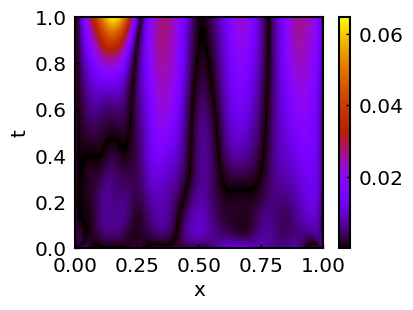

LOINN took 196.10043048858643 s.
The average l2 error is  0.032896078556918604


In [9]:
from deepxde.callbacks import Callback
os.environ["TF_XLA_FLAGS"] = '--tf_xla_cpu_global_jit'

class UpdateOutput(Callback):
    def __init__(self, Nx, Nt, dataset, net, pre_layers, best_step, x_train, dname):
        super(UpdateOutput, self).__init__()
        self.graph = tf.Graph()
        self.dataset = dataset
        self.Nx = Nx
        self.Nt = Nt
        self.x_train = x_train
        self.f_new = np.loadtxt(f"{dname}/f_new_grid.dat")
        self.u_new = np.loadtxt(f"{dname}/u_new_grid.dat")
        self.net_outputs = net.outputs
        self.feed_dict = net.feed_dict(False, self.x_train)
        with self.graph.as_default():
            self.trained_model = self.load_trained_model(dataset, pre_layers, best_step)

    def on_batch_begin(self):
        outputs = self.model.sess.run(self.net_outputs, feed_dict = self.feed_dict)
        outputs = outputs.reshape((self.Nx, self.Nt))

        with self.graph.as_default():
            train_u,_ = construct_data(self.f_new, outputs)
            pred_u = self.trained_model.predict(train_u)

        pred_u = pred_u.reshape((self.Nx-2, self.Nt-1))
        pred_u = np.concatenate((np.zeros((self.Nx-2, 1)), pred_u), axis = 1)
        pred_u = np.concatenate((np.zeros((1,self.Nt)), pred_u, np.zeros((1, self.Nt))), axis = 0)
        self.model.data.train_y = pred_u.reshape((-1, 1))

    def load_trained_model(self, data, layers, best_step):
        net = dde.nn.FNN(layers, "tanh", "LeCun normal", use_bias = True)
        model = dde.Model(data, net)
        model.compile("adam", lr=1e-3, decay = ("inverse time", 20000, 0.5), metrics=["l2 relative error"])
        model.compile("L-BFGS-B",  metrics=["l2 relative error"])
        model.restore("nonlinear_diffusion/model/model.ckpt-" + best_step + ".ckpt", verbose=1)
        return model

def solve_nn(Nx, Nt, dataset_G, data, pre_layers, best_step, dname, isplot=False):
    sname = "_g"
    os.makedirs(f"{dname}/history_LOINN{sname}", exist_ok = True)

    x_train = data.train_x

    # define the new model
    net = dde.nn.FNN([2] + [128]*2 + [1], "tanh", "LeCun normal")

    model = dde.Model(data, net)

    checker = dde.callbacks.ModelCheckpoint("nonlinear_diffusion/model/lmodel.ckpt", save_better_only=True, period=100000)
    model.compile("adam", lr=1e-3, decay = ("inverse time", 10000, 0.8), metrics=["l2 relative error"])
    update = UpdateOutput(Nx, Nt, dataset_G, net, pre_layers, best_step, x_train, dname)
    losshistory, train_state = model.train(epochs=2000)
    losshistory, train_state = model.train(epochs=1000,  callbacks=[update])
    losshistory, train_state = model.train(epochs=97000, disregard_previous_best=True,  callbacks=[update, checker], model_save_path = "nonlinear_diffusion/model/lmodel.ckpt")
    dde.saveplot(losshistory, train_state, issave=True, isplot=False, output_dir = f"{dname}/history_LOINN{sname}")
    # model.restore("nonlinear_diffusion/model/lmodel.ckpt-" + str(train_state.best_step)+".ckpt", verbose=1)

    #predict
    u_pred = model.predict(data.test_x)
    u_new = data.test_y
    err = dde.metrics.l2_relative_error(u_pred, u_new)
    np.savetxt(f"{dname}/u_LOINN{sname}.dat",u_pred)
    print("l2 relative error: ", err)
    u_pred = u_pred.reshape((Nx, Nt))
    u_new = u_new.reshape((Nx, Nt))
    if isplot:
        plt.imshow(np.rot90(abs(u_pred - u_new)), cmap = "gnuplot", extent=(0,1,0,1), aspect='auto')
        plt.colorbar()
        plt.xlabel("x")
        plt.ylabel("t")
        # plt.savefig(f"{dname}/res_LOINN{sname}.png")
        plt.show()
    return err, train_state.best_step

def main(sigma, num_func, parent_dir = "../data/", gen = False):
    M = 1001
    Nx, Nt = 101, 101
    N_f = 101*101
    N_b = Nx*2 + Nt - 2
    l, a = 0.01, 0.1
    l_new, a_new = 0.1, float(sigma)
    sname = "_g"

    # Create folders for the datasets
    new_dir = "data_nonlinear_diffusion"
    PATH = os.path.join(parent_dir, new_dir)
    
    best_step = "161943" 
    pre_layers = [4, 64, 1]
    errs = []
    b_steps = [[0] for i in range(num_func)]
    for i in range(num_func):
        print("Dataset {}".format(i))
        dname = f"{PATH}/data_{sigma}/data_{i}"
        dataset_G, dataset = load_all_data(M, Nx, Nt, N_f, N_b, l, a, l_new, a_new, 
                                 f"{PATH}/data_{sigma}/data_0", gen, 
                                 correction = False, grid = True, isplot = False)
        ts = time.time()
        err,b_step = solve_nn(Nx, Nt, dataset_G, dataset, pre_layers, best_step, dname, True)
        print("LOINN took {} s.".format(time.time()-ts))
        errs.append(err)
        b_steps[i][0] = b_step
        np.savetxt(os.path.join(f"{dname}", f"b_steps_LOINN{sname}.dat"), b_steps)

    # print(errs)
    np.savetxt(os.path.join(f"{dname}", f"errs_LOINN{sname}.dat"), errs)
    print("The average l2 error is ", sum(errs)/num_func)

main("0.80", 1)

**LOINN-random**

Dataset 0
Loaded f_T (1001, 1001) and u_T (1001, 1001) for training the local solution operator.
Loaded f_0_grid (101, 101) and u_0_grid (101, 101) for testing the local solution operator.
Loaded u_new (9900, 2) and u_new_grid (10201, 2) for x_train and x_test.
Dataset generated for LOINN-random (x_train, y_train, x_test, y_test).
Compiling model...
Building feed-forward neural network...
'build' took 0.045588 s

'compile' took 0.141134 s



2025-10-07 16:43:55.756536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


Compiling model...
Building feed-forward neural network...
'build' took 0.014919 s

'compile' took 0.075732 s

Compiling model...
'compile' took 0.022427 s

Restoring model from nonlinear_diffusion/model/model.ckpt-161943.ckpt ...

INFO:tensorflow:Restoring parameters from nonlinear_diffusion/model/model.ckpt-161943.ckpt
Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [2.07e-04]    [1.32e-01]    [9.76e-01]    


2025-10-07 16:43:56.042330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


1000      [1.56e-08]    [1.39e-01]    [1.00e+00]    
2000      [3.37e-06]    [1.40e-01]    [1.00e+00]    

Best model at step 1000:
  train loss: 1.56e-08
  test loss: 1.39e-01
  test metric: [1.00e+00]

'train' took 2.082639 s

Training model...

Step      Train loss    Test loss     Test metric   
2000      [3.37e-06]    [1.40e-01]    [1.00e+00]    
3000      [2.17e-06]    [1.45e-02]    [3.22e-01]    

Best model at step 1000:
  train loss: 1.56e-08
  test loss: 1.39e-01
  test metric: [1.00e+00]

'train' took 2.612124 s

Training model...

Step      Train loss    Test loss     Test metric   
3000      [2.17e-06]    [1.45e-02]    [3.22e-01]    
4000      [1.03e-06]    [5.17e-03]    [1.93e-01]    
5000      [3.61e-07]    [1.10e-03]    [8.88e-02]    
6000      [1.78e-07]    [4.83e-04]    [5.89e-02]    
7000      [1.12e-07]    [3.06e-04]    [4.69e-02]    
8000      [5.05e-07]    [2.31e-04]    [4.07e-02]    
9000      [5.61e-08]    [1.94e-04]    [3.73e-02]    
10000     [4.55e-08]    [1.

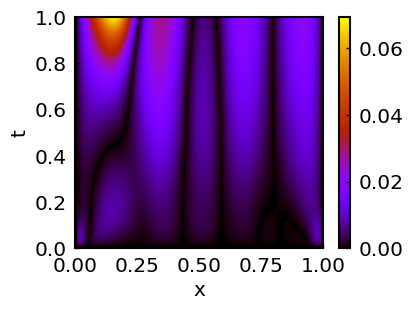

LOINN took 364.2779743671417 s.
The average l2 error is  0.03139231096305673


In [10]:
class UpdateOutput(Callback):
    def __init__(self, Nx, Nt, dataset, net, pre_layers, best_step, x_train, dname):
        super(UpdateOutput, self).__init__()
        self.graph = tf.Graph()
        self.dataset = dataset
        self.x_train = x_train
        self.hx = 1/(Nx-1)
        self.ht = 1/(Nt-1)
        self.f_new = np.loadtxt(f"{dname}/f_new.dat")[:, 2].reshape((-1,1))
        self.net_outputs = net.outputs
        self.feed_dict = net.feed_dict(False, self.get_inputs())
        with self.graph.as_default():
            self.trained_model = self.load_trained_model(dataset, pre_layers, best_step)

    def on_batch_begin(self):
        outputs = self.model.sess.run(self.net_outputs, feed_dict = self.feed_dict)
        with self.graph.as_default():
            train_u,_ = self.construct_local_domain(self.f_new, outputs)
            pred_u = self.trained_model.predict(train_u)

        self.model.data.train_y = pred_u

    def get_inputs(self):
        # u[i-1, j], u[i, j-1], u[i+1, j], f[i, j]
        x_l = np.array([[[xt[0] - self.hx, xt[1]]] for xt in self.x_train])
        x_b = np.array([[[xt[0], xt[1] - self.ht]] for xt in self.x_train])
        x_r = np.array([[[xt[0] + self.hx, xt[1]]] for xt in self.x_train])
        x = np.array([[[xt[0], xt[1]]] for xt in self.x_train])
        inputs = np.concatenate((x_l, x_b, x_r, x), axis = 1).reshape((-1, 2))
        return inputs

    def construct_local_domain(self, f, outputs):
        outputs_u = outputs[3::4]
        u_l = outputs[0::4]
        u_b = outputs[1::4]
        u_r = outputs[2::4]
        inputs = np.concatenate((u_l, u_b, u_r, f), axis = 1)
        return np.array(inputs), outputs_u

    def load_trained_model(self, data, layers, best_step):
        net = dde.nn.FNN(layers, "tanh", "LeCun normal", use_bias = True)
        model = dde.Model(data, net)
        model.compile("adam", lr=1e-3, decay = ("inverse time", 20000, 0.5), metrics=["l2 relative error"])
        model.compile("L-BFGS-B",  metrics=["l2 relative error"])
        model.restore("nonlinear_diffusion/model/model.ckpt-" + best_step + ".ckpt", verbose=1)
        return model

def solve_nn(Nx, Nt, dataset_G, data, pre_layers, best_step, dname, isplot=False):
    sname = "_r"
    os.makedirs(f"{dname}/history_LOINN{sname}", exist_ok = True)

    x_train = data.train_x

    # define the new model
    net = dde.nn.FNN([2] + [128]*2 + [1], "tanh", "LeCun normal")

    def output_transform(x, y):
        x0, t = x[:, 0:1], x[:, 1:2]
        return x0 * (x0 - 1) * t * y

    net.apply_output_transform(output_transform)
    model = dde.Model(data, net)
    
    checker = dde.callbacks.ModelCheckpoint("nonlinear_diffusion/model/lmodel.ckpt", save_better_only=True, period=100000)
    model.compile("adam", lr=1e-3, decay = ("inverse time", 10000, 0.8), metrics=["l2 relative error"])
    update = UpdateOutput(Nx, Nt, dataset_G, net, pre_layers, best_step, x_train, dname)
    losshistory, train_state = model.train(epochs=2000)
    losshistory, train_state = model.train(epochs=1000,  callbacks=[update])
    losshistory, train_state = model.train(epochs=97000, disregard_previous_best=True,  callbacks=[update, checker], model_save_path = "nonlinear_diffusion/model/lmodel.ckpt")
    dde.saveplot(losshistory, train_state, issave=True, isplot=False, output_dir = f"{dname}/history_LOINN{sname}")
    # model.restore("nonlinear_diffusion/model/lmodel.ckpt-" + str(train_state.best_step)+".ckpt", verbose=1)

    #predict
    u_pred = model.predict(data.test_x)
    u_new = data.test_y
    err = dde.metrics.l2_relative_error(u_pred, u_new)
    np.savetxt(f"{dname}/u_LOINN{sname}.dat",u_pred)
    print("l2 relative error: ", err)
    u_pred = u_pred.reshape((Nx, Nt))
    u_new = u_new.reshape((Nx, Nt))
    if isplot:
        plt.imshow(np.rot90(abs(u_pred - u_new)), cmap = "gnuplot", extent=(0,1,0,1), aspect='auto')
        plt.colorbar()
        plt.xlabel("x")
        plt.ylabel("t")
        # plt.savefig(f"{dname}/res_LOINN{sname}.png")
        plt.show()
    return err, train_state.best_step

def main(sigma, num_func, parent_dir = "../data/", gen = False):
    M = 1001
    Nx, Nt = 101, 101
    N_f = 101*101
    N_b = Nx*2 + Nt - 2
    l, a = 0.01, 0.1
    l_new, a_new = 0.1, float(sigma)
    sname = "_r"

    # Create folders for the datasets
    new_dir = "data_nonlinear_diffusion"
    PATH = os.path.join(parent_dir, new_dir)
    
    best_step = "161943" 
    pre_layers = [4, 64, 1]
    errs = []
    b_steps = [[0] for i in range(num_func)]
    for i in range(num_func):
        print("Dataset {}".format(i))
        dname = f"{PATH}/data_{sigma}/data_{i}"
        dataset_G, dataset = load_all_data(M, Nx, Nt, N_f, N_b, l, a, l_new, a_new, 
                                 f"{PATH}/data_{sigma}/data_0", gen, 
                                 correction = False, grid = False, isplot = False)
        ts = time.time()
        err,b_step = solve_nn(Nx, Nt, dataset_G, dataset, pre_layers, best_step, dname, True)
        print("LOINN took {} s.".format(time.time()-ts))
        errs.append(err)
        b_steps[i][0] = b_step
        np.savetxt(os.path.join(f"{dname}", f"b_steps_LOINN{sname}.dat"), b_steps)

    # print(errs)
    np.savetxt(os.path.join(f"{dname}", f"errs_LOINN{sname}.dat"), errs)
    print("The average l2 error is ", sum(errs)/num_func)

main("0.80", 1)

#### Approach 3: cLOINN

**cLOINN-grid**

In [15]:
class UpdateOutput(Callback):
    def __init__(self, Nx, Nt, dataset, net, pre_layers, best_step, x_train, l2_errs, dname):
        super(UpdateOutput, self).__init__()
        # load the pre-trained model
        self.graph = tf.Graph()
        self.dataset = dataset
        self.l2_errs = l2_errs
        self.x_train = x_train
        self.Nx = Nx
        self.Nt = Nt
        self.f_new = np.loadtxt(f"{dname}/f_new_grid.dat")
        self.u_new = np.loadtxt(f"{dname}/u_new_grid.dat")
        self.u_0 = np.loadtxt(f"{dname}/u_0_grid.dat")
        self.net_outputs = net.outputs
        self.feed_dict = net.feed_dict(False, self.x_train)
        self.l2_errs = l2_errs
        with self.graph.as_default():
            self.trained_model = self.load_trained_model(dataset, pre_layers, best_step)

    def on_batch_begin(self):
        outputs = self.model.sess.run(self.net_outputs, feed_dict = self.feed_dict)
        outputs = outputs.reshape((self.Nx, self.Nt)) + self.u_0

        with self.graph.as_default():
            train_u,_ = construct_data(self.f_new, outputs)
            pred_u = self.trained_model.predict(train_u)

        pred_u = pred_u.reshape((self.Nx-2, self.Nt-1))
        pred_u = np.concatenate((np.zeros((self.Nx-2, 1)), pred_u), axis = 1)
        pred_u = np.concatenate((np.zeros((1, self.Nt)), pred_u, np.zeros((1, self.Nt))), axis = 0)

        self.model.data.train_y = pred_u.reshape((-1, 1)) - self.u_0.reshape((-1, 1))

        if self.model.train_state.epoch % 1000 == 0:
            err = np.linalg.norm(outputs - self.u_new)/np.linalg.norm(self.u_new)
            self.l2_errs.append([self.model.train_state.epoch, err])
            print(self.model.train_state.epoch, "l2 relative error: ",err)

    def load_trained_model(self, data, layers, best_step):
        net = dde.nn.FNN(layers, "tanh", "LeCun normal", use_bias = True, regularization=['l2', 1e-8])
        model = dde.Model(data, net)
        model.compile("adam", lr=1e-3, decay = ("inverse time", 20000, 0.5), metrics=["l2 relative error"])
        model.compile("L-BFGS-B",  metrics=["l2 relative error"])
        model.restore("nonlinear_diffusion/model/model.ckpt-" + best_step + ".ckpt", verbose=1)
        return model


def solve_nn(Nx, Nt, dataset_G, data, pre_layers, best_step, dname, PATH, isplot=False):
    sname = "_g"
    os.makedirs(f"{dname}/history_cLOINN{sname}", exist_ok = True)
    x_train = data.train_x
    l2_errs = []
    net = dde.nn.FNN([2] + [128]*2 + [1], "tanh", "LeCun normal")
    model = dde.Model(data, net)

    iters = 100000
    checker = dde.callbacks.ModelCheckpoint("nonlinear_diffusion/model/clmodel.ckpt", save_better_only=True, period=100000)
    model.compile("adam", lr=1e-3, decay = ("inverse time", 10000, 0.8), metrics=["l2 relative error"])
    update = UpdateOutput(Nx, Nt, dataset_G, net, pre_layers, best_step, x_train, l2_errs, dname)
    losshistory, train_state = model.train(epochs=iters,disregard_previous_best=True,  callbacks=[update, checker], model_save_path = "nonlinear_diffusion/model/clmodel.ckpt")
    dde.saveplot(losshistory, train_state, issave=True, isplot = False, output_dir = f"{dname}/history_cLOINN{sname}")

    u_0 = np.loadtxt(f"{dname}/u_0_grid.dat").reshape((-1,1))
    u_true = np.loadtxt(f"{dname}/u_new_grid.dat").reshape((-1,1))

    u_pred = model.predict(data.test_x)+u_0
    u_pred = u_pred.reshape((-1,1))
    err = dde.metrics.l2_relative_error(u_pred, u_true)
    print("l2 relative error: ", err)
    np.savetxt(f"{dname}/u_cLOINN{sname}.dat",u_pred)

    l2_errs.append([iters,  err])
    l2_errs = np.array(l2_errs).reshape((-1,2))
    # print(l2_errs)
    np.savetxt(f"{dname}/err_cLOINN{sname}.dat", l2_errs)
    if isplot:
        fig = plt.figure()
        plt.rcParams.update({'font.size': 20})
        plt.plot(l2_errs[:,0], l2_errs[:, 1])
        plt.xlabel("# Epochs")
        plt.ylabel("$L^2$ relative error")
        plt.savefig(f"{dname}/err_cLOINN{sname}.png")
        plt.show()
    return err, train_state.best_step

def main(sigma, num_func, parent_dir = "../data/", gen = False):
    M = 1001
    Nx, Nt = 101, 101
    N_f = 101*101
    N_b = Nx*2 + Nt - 2
    l, a = 0.01, 0.1
    l_new, a_new = 0.1, float(sigma)

    # Create folders for the datasets
    new_dir = "data_nonlinear_diffusion"
    PATH = os.path.join(parent_dir, new_dir)

    best_step = "161943"
    pre_layers = [4, 64, 1]
    errs = []
    b_steps = [[0] for i in range(num_func)]
    for i in range(num_func):
        print("Dataset {}".format(i))
        dname = f"{PATH}/data_{sigma}/data_{i}"
        dataset_G, dataset = load_all_data(M, Nx, Nt, N_f, N_b, l, a, l_new, a_new, dname, gen, 
                                      correction = True, grid = True, isplot = False)
        #err,b_step = apply(solve_nn, (Nx, Ny, dataset_G, dataset, pre_layers, best_step, dname, PATH, True))
        ts = time.time()
        err,b_step = solve_nn(Nx, Nt, dataset_G, dataset, pre_layers, best_step, dname, PATH)
        print("cLOINN took {} s.".format(time.time()-ts))
        errs.append(err)
        b_steps[i][0] = b_step
        np.savetxt(os.path.join(f"{PATH}/data_{sigma}/", f"b_steps_cLOINN_g.dat"), b_steps)

    # print(errs)
    np.savetxt(os.path.join(f"{PATH}/data_{sigma}/", f"errs_cLOINN_g.dat"), errs)
    print("The average l2 error is ", sum(errs)/num_func)

main("0.80", 1)

Dataset 0
Loaded f_T (1001, 1001) and u_T (1001, 1001) for training the local solution operator.
Loaded f_0_grid (101, 101) and u_0_grid (101, 101) for testing the local solution operator.
Loaded u_new_grid (10201, 2) for x_train and x_test.
Dataset generated for cLOINN-grid (x_train, y_train, x_test, y_test).
Compiling model...
Building feed-forward neural network...
'build' took 0.022935 s

'compile' took 0.144308 s

Compiling model...
Building feed-forward neural network...
'build' took 0.016235 s



/gpfs/radev/home/aj733/.conda/envs/tf-condacuda/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2025-10-07 17:05:47.410758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
2025-10-07 17:05:47.557929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


'compile' took 0.083896 s

Compiling model...
'compile' took 0.027055 s

Restoring model from nonlinear_diffusion/model/model.ckpt-161943.ckpt ...

INFO:tensorflow:Restoring parameters from nonlinear_diffusion/model/model.ckpt-161943.ckpt
Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [1.16e-01]    [3.10e-01]    [1.88e+00]    
0 l2 relative error:  1.4930497097257471
1000      [2.51e-04]    [5.94e-02]    [8.22e-01]    
1000 l2 relative error:  0.6530608673915267
2000      [3.82e-05]    [1.45e-02]    [4.06e-01]    
2000 l2 relative error:  0.3225128380868027
3000      [4.19e-04]    [1.05e-02]    [3.45e-01]    
3000 l2 relative error:  0.2742207138243765
4000      [1.65e-05]    [6.57e-03]    [2.73e-01]    
4000 l2 relative error:  0.217206428248729
5000      [1.17e-05]    [3.16e-03]    [1.90e-01]    
5000 l2 relative error:  0.15064842093199093
6000      [6.93e-06]    [1.32e-03]    [1.23e-01]    
6000 l2 relative error:  0.0973

**cLOINN-random**

In [16]:
class UpdateOutput(Callback):
    def __init__(self, Nx, Nt, dataset, net, pre_layers, best_step, x_train, l2_errs, dname, PATH):
        super(UpdateOutput, self).__init__()
        # load the pre-trained model
        self.graph = tf.Graph()
        self.dataset = dataset
        self.l2_errs = l2_errs
        self.x_train = x_train
        self.Nx = Nx
        self.Nt = Nt
        self.hx = 1/(Nx-1)
        self.ht = 1/(Nt-1)
        self.net = net
        self.u_0_grid = np.loadtxt(f"{dname}/u_0_grid.dat").reshape((-1, 1))
        self.u_new_grid = np.loadtxt(f"{dname}/u_new_grid.dat").reshape((-1, 1))
        self.f_new = np.loadtxt(f"{dname}/f_new.dat")[:, 2].reshape((-1, 1))
        self.u_new = np.loadtxt(f"{dname}/u_new.dat")[:, 2].reshape((-1, 1))
        self.u_init = np.loadtxt(f"{dname}/u_init.dat")[:, 2].reshape((-1, 1))
        self.net_outputs = net.outputs
        self.inputs = self.get_inputs()
        #print(self.inputs.shape)
        self.feed_dict = net.feed_dict(False, self.inputs)
        self.u_0 = self.get_u_0(PATH)
        self.l2_errs = l2_errs
        with self.graph.as_default():
            self.trained_model = self.load_trained_model(dataset, pre_layers, best_step)

    def on_batch_begin(self):
        # get the outputs  
        outputs = self.model.sess.run(self.net_outputs, feed_dict = self.feed_dict)
        pred_grid = self.model.sess.run(self.net_outputs, feed_dict = self.net.feed_dict(False, self.model.data.test_x))
        outputs = outputs + self.u_0

        with self.graph.as_default():
            train_u,_ = self.construct_local_domain(self.f_new, outputs)  # (9900, 4)
            pred_u = self.trained_model.predict(train_u) #(9900, 1)

        #print(pred_u.shape, self.u_init.shape)
        self.model.data.train_y = pred_u - self.u_init
        
        
        if self.model.train_state.epoch % 1000 == 0:
            err = np.linalg.norm(pred_grid + self.u_0_grid - self.u_new_grid)/np.linalg.norm(self.u_new_grid)
            self.l2_errs.append([self.model.train_state.epoch, err])
            print(self.model.train_state.epoch, "Prediction l2 relative error: ",err)

        if self.model.train_state.epoch % 1000 == 0:
            err = np.linalg.norm(outputs[3::4] - self.u_new)/np.linalg.norm(self.u_new)
            #self.l2_errs.append([self.model.train_state.epoch, err])
            print(self.model.train_state.epoch, "l2 relative error: ",err)

    def get_u_0(self, PATH):
        x = np.linspace(0,1,1001)
        t = np.linspace(0,1,1001)
        u_0 = np.loadtxt(f"{PATH}/data_G/u_0.dat")
        interp = interpolate.RegularGridInterpolator((x, t), u_0, method='cubic', bounds_error=False, fill_value=0 )
        u_0_new = np.array([interp((i[0], i[1])) for i in self.inputs]).reshape((-1, 1))
        return u_0_new

    def get_inputs(self):
        # u[i-1, j], u[i, j-1], u[i+1, j], f[i, j]
        print(self.x_train.shape)
        x_l = np.array([[[xt[0] - self.hx, xt[1]]] for xt in self.x_train])
        x_b = np.array([[[xt[0], xt[1] - self.ht]] for xt in self.x_train])
        x_r = np.array([[[xt[0] + self.hx, xt[1]]] for xt in self.x_train])
        x = np.array([[[xt[0], xt[1]]] for xt in self.x_train])
        #print(x_l, x_b, x_r, x)
        inputs = np.concatenate((x_l, x_b, x_r, x), axis = 1).reshape((-1, 2))  #(300,)
        return inputs

    def construct_local_domain(self, f, outputs):
        #print(outputs.shape)
        outputs_u = outputs[3::4]# (103,1)
        u_l = outputs[0::4]
        u_b = outputs[1::4]
        u_r = outputs[2::4]
        #print(u_l, u_b, u_r)
        inputs = np.concatenate((u_l, u_b, u_r, f), axis = 1)
        return np.array(inputs), outputs_u

    def load_trained_model(self, data, layers, best_step):
        net = dde.nn.FNN(layers, "tanh", "LeCun normal", use_bias = True, regularization=['l2', 1e-8])
        model = dde.Model(data, net)
        # restore model
        model.compile("adam", lr=1e-3, decay = ("inverse time", 2000, 0.5), metrics=["l2 relative error"])
        model.compile("L-BFGS-B",  metrics=["l2 relative error"])
        model.restore("nonlinear_diffusion/model/model.ckpt-" + best_step + ".ckpt", verbose=1)
        return model

def solve_nn(Nx, Nt, dataset_G, data, pre_layers, best_step, dname, PATH, isplot=False):
    os.makedirs(f"{dname}/history_cLOINN_r", exist_ok = True)
    # new source function
    x_train = data.train_x

    l2_errs = []
    # define the new model
    net = dde.nn.FNN([2] + [128]*2 + [1], "tanh", "LeCun normal")

    def output_transform(x, y):
        x0, t = x[:, 0:1], x[:, 1:2]
        return x0 * (x0 - 1) * t * y

    net.apply_output_transform(output_transform)
    model = dde.Model(data, net)

    iters = 100000
    checker = dde.callbacks.ModelCheckpoint("nonlinear_diffusion/model/clmodel.ckpt", save_better_only=True, period=100000)
    model.compile("adam", lr=1e-3, decay = ("inverse time", iters // 10, 0.8), metrics=["l2 relative error"])
    update = UpdateOutput(Nx, Nt, dataset_G, net, pre_layers, best_step, x_train, l2_errs, dname, PATH)
    losshistory, train_state = model.train(epochs=iters,disregard_previous_best=True,  callbacks=[update, checker], model_save_path = f"nonlinear_diffusion/model/clmodel.ckpt")
    dde.saveplot(losshistory, train_state, issave=True, isplot = False, output_dir = f"{dname}/history_cLOINN_r")
    # model.restore(f"nonlinear_diffusion/model/clmodel.ckpt-{iters}.ckpt", verbose=1)

    #predict
    u_0 = np.loadtxt(f"{dname}/u_0_grid.dat").reshape((-1,1))
    u_true = np.loadtxt(f"{dname}/u_new_grid.dat").reshape((-1,1))
    u_pred = model.predict(data.test_x)+u_0
    u_pred = u_pred.reshape((-1,1))
    err = dde.metrics.l2_relative_error(u_pred, u_true)
    print("l2 relative error: ", err)
    print(u_pred.shape)
    np.savetxt(f"{dname}/u_cLOINN_r.dat",u_pred)

    l2_errs.append([iters,  err])
    l2_errs = np.array(l2_errs).reshape((-1,2))
    # print(l2_errs)
    np.savetxt(f"{dname}/err_cLOINN_r.dat",l2_errs)
    return err, train_state.best_step

def main(sigma, num_func, parent_dir = "../data/", gen = False):
    M = 1001
    Nx, Nt = 101, 101
    N_f = 101*101
    N_b = Nx*2 + Nt - 2
    l, a = 0.01, 0.1
    l_new, a_new = 0.1, float(sigma)

    # Create folders for the datasets
    new_dir = "data_nonlinear_diffusion"
    PATH = os.path.join(parent_dir, new_dir)

    best_step = "161943"
    pre_layers = [4, 64, 1]
    errs = []
    b_steps = [[0] for i in range(num_func)]
    for i in range(num_func):
        print("Dataset {}".format(i))
        dname = f"{PATH}/data_{sigma}/data_{i}"
        dataset_G, dataset = load_all_data(M, Nx, Nt, N_f, N_b, l, a, l_new, a_new, dname, gen, 
                                      correction = True, grid = False, isplot = False)
        #err,b_step = apply(solve_nn, (Nx, Ny, dataset_G, dataset, pre_layers, best_step, dname, PATH, True))
        ts = time.time()
        err,b_step = solve_nn(Nx, Nt, dataset_G, dataset, pre_layers, best_step, dname, PATH)
        print("cLOINN took {} s.".format(time.time()-ts))
        errs.append(err)
        b_steps[i][0] = b_step
        np.savetxt(os.path.join(f"{PATH}/data_{sigma}/", f"b_steps_cLOINN_r.dat"), b_steps)

    # print(errs)
    np.savetxt(os.path.join(f"{PATH}/data_{sigma}/", f"errs_cLOINN_r.dat"), errs)
    print("The average l2 error is ", sum(errs)/num_func)

main("0.80", 1)

Dataset 0
Loaded f_T (1001, 1001) and u_T (1001, 1001) for training the local solution operator.
Loaded f_0_grid (101, 101) and u_0_grid (101, 101) for testing the local solution operator.
Loaded u_new (9900, 2) and u_new_grid (10201, 2) for x_train and x_test.
Dataset generated for cLOINN-random (x_train, y_train, x_test, y_test).
Compiling model...
Building feed-forward neural network...
'build' took 0.026247 s

'compile' took 0.159439 s

(9900, 2)


2025-10-07 17:09:07.920486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


Compiling model...
Building feed-forward neural network...
'build' took 0.016771 s

'compile' took 0.085314 s

Compiling model...
'compile' took 0.025975 s

Restoring model from nonlinear_diffusion/model/model.ckpt-161943.ckpt ...

INFO:tensorflow:Restoring parameters from nonlinear_diffusion/model/model.ckpt-161943.ckpt
Initializing variables...


2025-10-07 17:09:13.061259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


Training model...

Step      Train loss    Test loss     Test metric   
0         [5.24e-05]    [8.58e-02]    [9.88e-01]    
0 Prediction l2 relative error:  0.7849066044132256
0 l2 relative error:  0.7850779864779925
1000      [2.83e-07]    [9.12e-04]    [1.02e-01]    
1000 Prediction l2 relative error:  0.08092619889528645
1000 l2 relative error:  0.08115849693994588
2000      [1.19e-07]    [3.29e-04]    [6.12e-02]    
2000 Prediction l2 relative error:  0.04859468672784816
2000 l2 relative error:  0.048573438093703285
3000      [6.65e-08]    [2.15e-04]    [4.95e-02]    
3000 Prediction l2 relative error:  0.03929771578581207
3000 l2 relative error:  0.03917402102050424
4000      [4.46e-08]    [1.77e-04]    [4.49e-02]    
4000 Prediction l2 relative error:  0.03568322757097929
4000 l2 relative error:  0.03551313038312567
5000      [3.36e-08]    [1.62e-04]    [4.29e-02]    
5000 Prediction l2 relative error:  0.03407172429377773
5000 l2 relative error:  0.03387880728347891
6000      [

We show a test example for $\sigma$= 0.8 and the predictions and pointwise errors using FPI, LOINN-grid, cLOINN-grid, LOINN-random, and cLOINN-random.

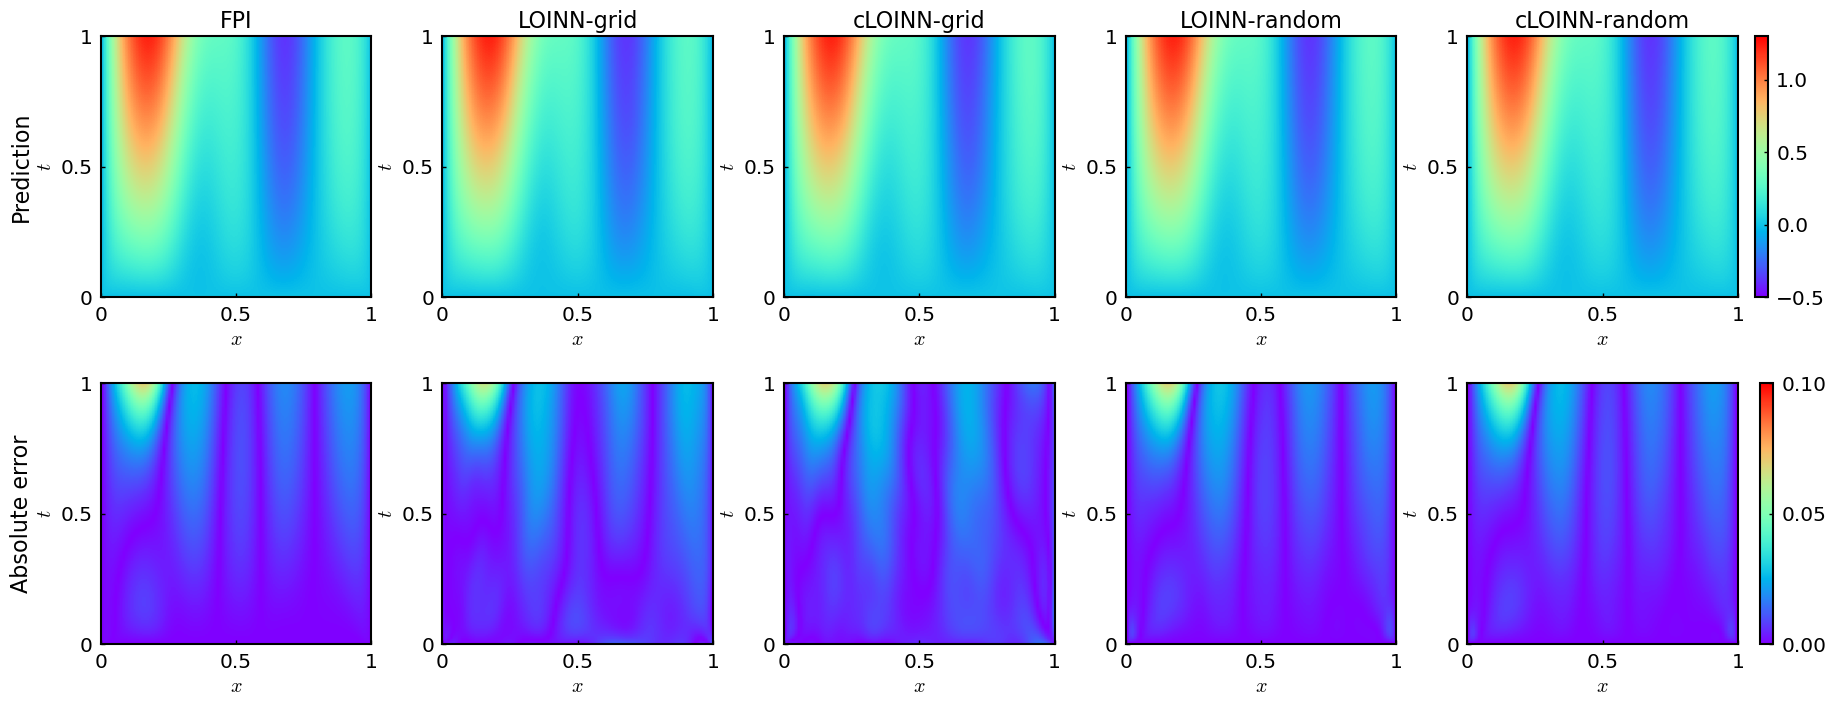

In [17]:
import matplotlib.gridspec as gridspec
import scipy
PATH = "../data/data_nonlinear_diffusion"
cmap = "rainbow"
extent = (0, 1, 0, 1)
aspect = 'auto'
origin = 'upper'
fig = plt.figure(figsize=(22, 8))
outer = fig.add_gridspec(
    nrows=2, ncols=1,
    height_ratios=[2.2, 2.2],
    hspace=0.36
)

dname0 = f"{PATH}/data_0.80/data_0"
x = np.linspace(0, 1, 1001)
x_grid = np.linspace(0, 1, 101)

u_new  = np.loadtxt(f"{dname0}/u_new_grid.dat").reshape((101,101))
f_new  = np.loadtxt(f"{dname0}/f_new_grid.dat")[:,0]
interp_func = scipy.interpolate.interp1d(x_grid, f_new, kind='cubic') 
f_new = interp_func(x)
u_new = np.rot90(u_new)

gsD = outer[0].subgridspec(1, 5, width_ratios=[1,1,1,1,1.25], wspace=0.25)
axesD = [fig.add_subplot(gsD[0, i]) for i in range(5)]
u_new  = np.loadtxt(f"{dname0}/u_new_grid.dat").reshape((101,101))
u_FPI_orig  = np.loadtxt(f"{dname0}/u_FPI_G.dat").reshape((101,101))
u_gLOINN  = np.loadtxt(f"{dname0}/u_LOINN_g.dat").reshape((101,101))
u_gcLOINN  = np.loadtxt(f"{dname0}/u_cLOINN_g.dat").reshape((101,101))
u_rLOINN  = np.loadtxt(f"{dname0}/u_LOINN_r.dat").reshape((101,101))
u_rcLOINN  = np.loadtxt(f"{dname0}/u_cLOINN_r.dat").reshape((101,101))
u_preds = [u_FPI_orig, u_gLOINN, u_gcLOINN, u_rLOINN, u_rcLOINN]

for ax, method, i in zip(axesD, ["FPI","LOINN-grid","cLOINN-grid","LOINN-random","cLOINN-random"], range(5)):
    im = ax.imshow(np.rot90(u_preds[i]), cmap=cmap, extent=extent, aspect=aspect, origin=origin, vmin = -0.5, vmax = 1.3)
    if method == "cLOINN-random":
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_ticks([-0.5, 0.0, 0.5, 1.0])    
    ax.set_title(method)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    ax.set_xticks([0, 0.5, 1], [0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1], [0, 0.5, 1])

# ───────────────────────────────────
gsE = outer[1].subgridspec(1, 5, width_ratios=[1,1,1,1,1.25], wspace=0.25)
axesE = [fig.add_subplot(gsE[0, i]) for i in range(5)]
for ax, method, i in zip(axesE, ["FPI","LOINN-grid","cLOINN-grid","LOINN-random","cLOINN-random"], range(5)):
    im = ax.imshow(np.rot90(abs(u_preds[i]-u_new)), cmap=cmap, extent=extent, aspect=aspect, origin=origin, vmin = 0, vmax = 0.10)
    if method == "cLOINN-random":
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_ticks([0.0, 0.05, 0.10])
    # ax.set_title(method)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    ax.set_xticks([0, 0.5, 1], [0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1], [0, 0.5, 1])
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.01, pos.width, pos.height])
    if method == "cLOINN-random":
        cbar.ax.set_position([pos.x1+0.01, pos.y0 + 0.01, 0.02, pos.height])

axesD[0].text(
    -0.25, 0.5, "Prediction",
    transform=axesD[0].transAxes,
    va="center", ha="right",rotation=90,
    fontsize=fontsize, fontweight="normal"
)

axesE[0].text(
    -0.25, 0.5, "Absolute error",
    transform=axesE[0].transAxes,
    va="center", ha="right",rotation=90,
    fontsize=fontsize, fontweight="normal"
)

plt.show()

### Generalization of the local solution operator to very different testing functions

We evaluate the generalization capability of the local solution operator $\tilde{\mathcal{G}}$, which is trained from the sine wave  
$f_{\mathcal{T}}(x) = f_{\text{random}}(x) + \sin(2\pi x)$ and the corresponding $u_{\mathcal{T}}(x)$.  
We test it on various new $f$, including:  
(1) a phase-shifted sine wave, $f = \sin(2\pi x + \pi)$ (Fig. 5a);  
(2) a cosine wave, $f = \cos(2\pi x)$ (Fig. 5b);  
(3) a higher-frequency sine wave, $f = \sin(3\pi x)$ (Fig. 5c);  
(4) a sine wave with very high frequency, $f = 2\sin(9\pi x)$ (Fig. 5d);  
(5) a sum of two sine waves at moderate and high frequencies, $f = \sin(6\pi x) + \sin(14\pi x)$ (Fig. 5e); and  
(6) a sum of multiple weighted sine waves at different frequencies,  
$f = 0.8\sin(6\pi x) + 0.6\sin(14\pi x) + 0.4\sin(26\pi x) + 0.2\sin(42\pi x)$ (Fig. 5f).  

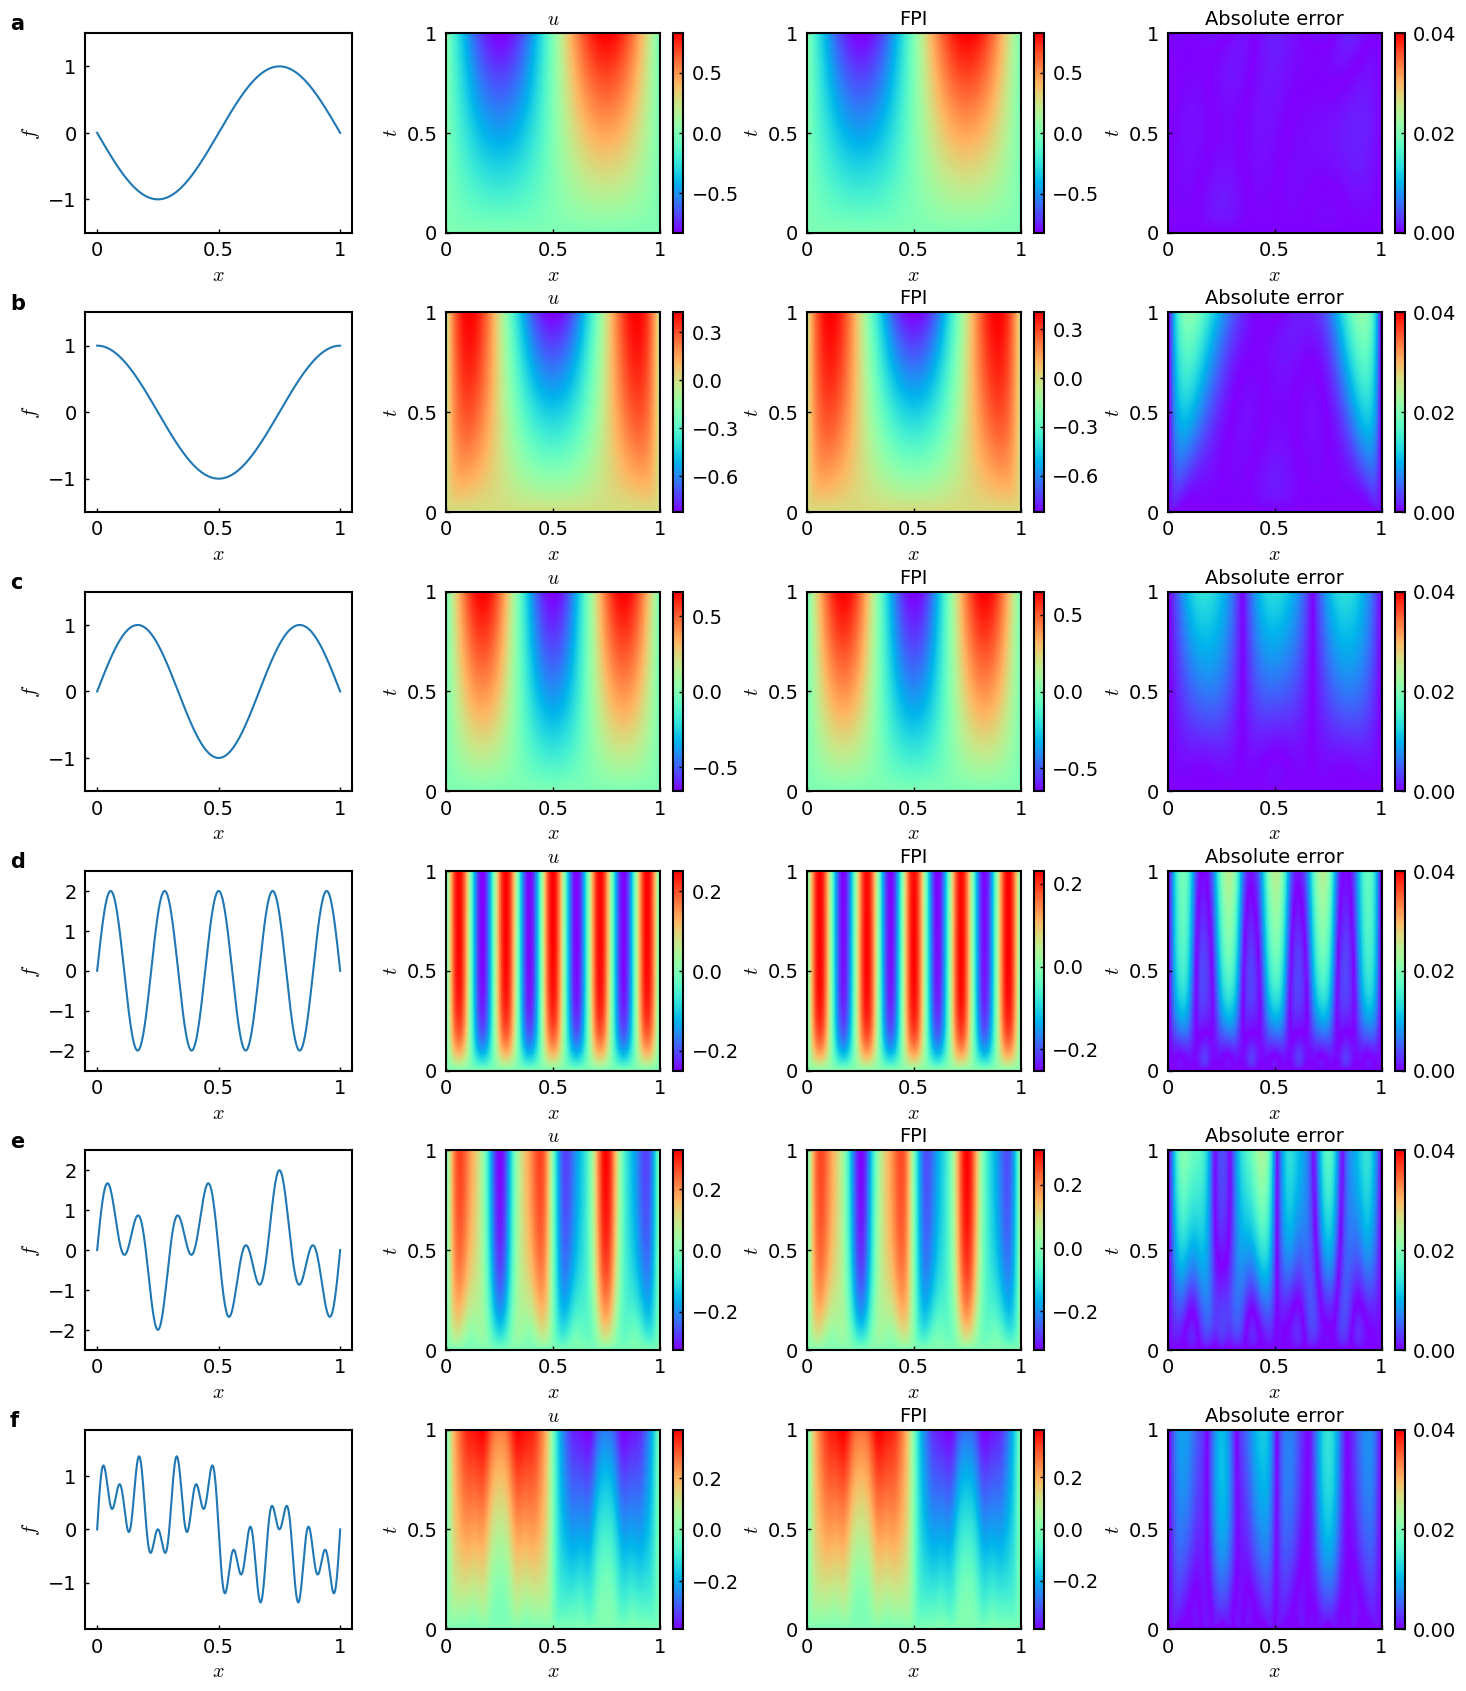

In [18]:
fontsize=15
fig_params = {
    'font.size': fontsize,
    "savefig.dpi": 300, 
    "figure.figsize": (20, 18),
    'lines.linewidth': 1.5,
    'axes.linewidth': 1.5,
    'axes.titlesize' : fontsize-1,
    #"axes.labelsize":fontsize+5,
    "xtick.labelsize":fontsize-1,
    "ytick.labelsize":fontsize-1,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'xtick.major.size': 3,
    'xtick.minor.size': 2,
    'xtick.major.width': 1,
    'xtick.minor.width': 1,
    'xtick.major.pad': 6,
    'xtick.minor.pad': 5,
    'ytick.major.pad': 6,
    'ytick.minor.pad': 5,
    'ytick.major.size': 3,
    'ytick.minor.size': 2,
    'ytick.major.width': 1,
    'ytick.minor.width': 1,
    "mathtext.fontset":"cm"
}
plt.rcParams.update(fig_params)

PATH = "../data/data_nonlinear_diffusion"
ftypes = ["sin", "cos", "freq", "hfreq", "twofreqs", "morefreqs"]
f_new_list = [np.loadtxt(f"{PATH}/data_0.80_{ftype}/data_0/f_new.dat")[:,0] for ftype in ftypes]
u_new_list = [np.loadtxt(f"{PATH}/data_0.80_{ftype}/data_0/u_new_grid.dat") for ftype in ftypes]
u_pred_list = [np.loadtxt(f"{PATH}/data_0.80_{ftype}/data_0/u_FPI_{ftype}.dat") for ftype in ftypes]
errors_list = [np.abs(u_new_list[i] - u_pred_list[i]) for i in range(len(ftypes))]
x = np.linspace(0, 1, 1001)
x_grid = np.linspace(0, 1, 101)
fig, axes = plt.subplots(len(ftypes), 4, figsize=(15, 19))
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.08, wspace=0.35, hspace=0.4)

cmap = "rainbow"
extent = (0, 1, 0, 1)
aspect = 'auto'
origin = 'upper'
row_labels = ['a', 'b', 'c', 'd', 'e', 'f']

for i in range(len(ftypes)):
    pos = axes[i, 0].get_position()
    fig.text(
        0.03, pos.y1 + 0.01, 
        row_labels[i],
        fontsize=fontsize,
        fontweight=570,
        va='top',ha='left'
    )
    
    ax0 = axes[i, 0]
    ax0.plot(x, f_new_list[i])
    ax0.set_ylabel("$f$")
    ax0.set_ylim(np.min(f_new_list[i]) - 0.5, np.max(f_new_list[i]) + 0.5)
    ax0.set_xlabel("$x$")

    ax1 = axes[i, 1]
    im1 = ax1.imshow(np.rot90(u_new_list[i]), cmap=cmap, extent=extent, aspect=aspect, origin=origin)
    cbar1 = fig.colorbar(im1, ax=ax1)
    if i==1:
        cbar1.set_ticks([-0.6, -0.3, 0.0, 0.3])
    elif i==3:
        cbar1.set_ticks([-0.2, 0.0, 0.2])
    ax1.set_title("$u$")
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$t$")

    ax2 = axes[i, 2]
    im2 = ax2.imshow(np.rot90(u_pred_list[i]), cmap=cmap, extent=extent, aspect=aspect, origin=origin)
    cbar2 = fig.colorbar(im2, ax=ax2)
    if i==1:
        cbar2.set_ticks([-0.6, -0.3, 0.0, 0.3])
    elif i==3:
        cbar2.set_ticks([-0.2, 0.0, 0.2])
    ax2.set_title("FPI")
    ax2.set_xlabel("$x$")
    ax2.set_ylabel("$t$")

    ax3 = axes[i, 3]
    im3 = ax3.imshow(np.rot90(errors_list[i]), cmap=cmap, extent=extent, aspect=aspect, origin=origin, vmin=0, vmax=0.04)
    cbar3 = fig.colorbar(im3, ax=ax3)
    cbar3.set_ticks([0.0, 0.02, 0.04])
    ax3.set_title("Absolute error")
    ax3.set_xlabel("$x$")
    ax3.set_ylabel("$t$")

    for j, ax in enumerate([ax0, ax1, ax2, ax3]):
        ax.set_xticks([0, 0.5, 1], [0, 0.5, 1])
        if j > 0:
            ax.set_yticks([0, 0.5, 1], [0, 0.5, 1])
            ax.set_yticklabels(['0', '0.5', '1'])

plt.show()

The results indicates that the local solution operator has a good generalizability and effectively captures the local relationship of the nonlinear diffusion-reaction equation.

### Generalization of the local solution operator to noisy testing input functions

We apply the same trained local solution operator Ge to the noisy testing functions of the cosine wave f = cos(2$\pi$x). We corrupt the
testing function with 5%, 10%, 20%, and 30% Gaussian noise. Notably, even when the added noise is 30%, the error remains relatively small (8.90%).

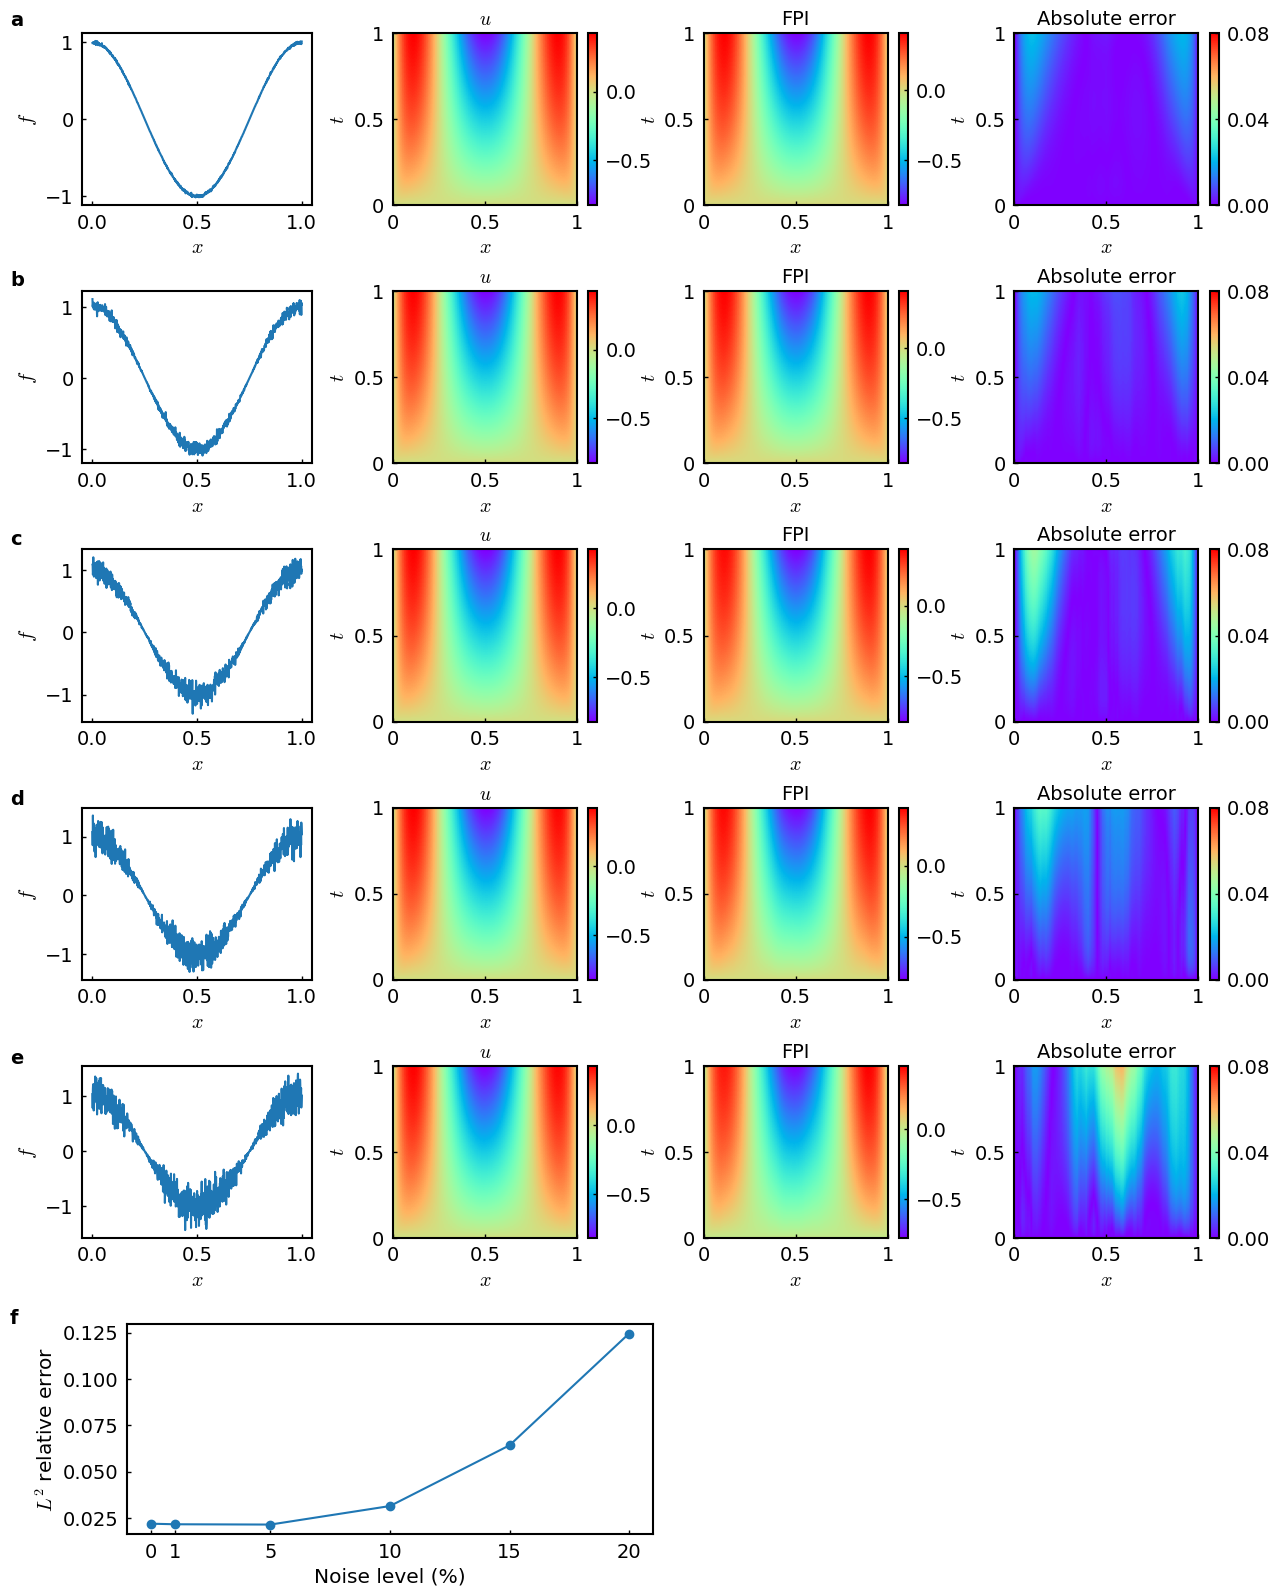

In [20]:
from matplotlib.gridspec import GridSpec
ftypes = ["noise1", "noise5", "noise10", "noise15", "noise20"]
row_lbl = ['a', 'b', 'c', 'd', 'e', 'f']
f_new_list  = [np.loadtxt(f"{PATH}/data_0.80_{ftype}/data_0/f_new.dat")[:, 0]
               for ftype in ftypes]
u_new_list  = [np.loadtxt(f"{PATH}/data_0.80_{ftype}/data_0/u_new_grid.dat")
               for ftype in ftypes]
u_pred_list = [np.loadtxt(f"{PATH}/data_0.80_{ftype}/data_0/u_FPI_{ftype}.dat")
               for ftype in ftypes]
errors_list = [np.abs(u_new_list[i] - u_pred_list[i]) for i in range(len(ftypes))]

x       = np.linspace(0, 1, 1001)
cmap    = "rainbow"
extent  = (0, 1, 0, 1)
fig = plt.figure(figsize=(15, 19))
gs  = GridSpec(len(ftypes) + 1, 4, figure=fig, hspace=0.50, wspace=0.35)
for i, lbl in enumerate(row_lbl[:-1]):
    # (1) f(x)
    ax0 = fig.add_subplot(gs[i, 0])
    ax0.plot(x, f_new_list[i])
    ax0.set(xlabel="$x$", ylabel="$f$")

    # (2) ground-truth u
    ax1 = fig.add_subplot(gs[i, 1])
    im1 = ax1.imshow(np.rot90(u_new_list[i]), cmap=cmap,
                     extent=extent, origin='upper', aspect='auto')
    fig.colorbar(im1, ax=ax1)
    ax1.set(title="$u$", xlabel="$x$", ylabel="$t$")

    # (3) FPI prediction
    ax2 = fig.add_subplot(gs[i, 2])
    im2 = ax2.imshow(np.rot90(u_pred_list[i]), cmap=cmap,
                     extent=extent, origin='upper', aspect='auto')
    fig.colorbar(im2, ax=ax2)
    ax2.set(title="FPI", xlabel="$x$", ylabel="$t$")

    # (4) absolute error
    ax3 = fig.add_subplot(gs[i, 3])
    im3 = ax3.imshow(np.rot90(errors_list[i]), cmap=cmap,
                     extent=extent, origin='upper', aspect='auto',
                     vmin=0, vmax=0.08)
    fig.colorbar(im3, ax=ax3, ticks=[0, 0.04, 0.08])
    ax3.set(title="Absolute error", xlabel="$x$", ylabel="$t$")

    # Shared ticks
    for ax in (ax1, ax2, ax3):
        ax.set_xticks([0, .5, 1], [0, .5, 1])
        ax.set_yticks([0, .5, 1], [0, .5, 1])

ax_err = fig.add_subplot(gs[-1, :-2]) 
noise_levels = [0, 1, 5, 10, 15, 20]
noise_errors = [0.02194, 0.02163, 0.02147, 0.03147, 0.06423, 0.12456] 
ax_err.plot(noise_levels, noise_errors, "o-")
ax_err.set_xticks(noise_levels, noise_levels)
ax_err.set_xlabel("Noise level (%)")
ax_err.set_ylabel(r"$L^2$ relative error")
pos = ax_err.get_position()
ax_err.set_position([pos.x0+0.03, pos.y0-0.02, pos.width-0.01, pos.height+0.02])

for i, lbl in enumerate(row_lbl):
    pos = (0.077, 1 - (i+0.85)/(len(ftypes)+2.32))
    fig.text(*pos, lbl, fontsize=14, fontweight='bold')

plt.show()